In [109]:
import base64
import datetime
import itertools
import json
import math
import operator
import os
import pickle
import random
import re
import time

import scipy
from scipy import ndimage
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import statsmodels as sm
from pylab import rcParams
from pylab import *
from matplotlib.dates import date2num , DateFormatter
from PIL import Image

np.random.seed(1337)

%matplotlib inline
sns.set(font_scale=1.0)
rcParams['figure.figsize'] = 8, 6
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

In [110]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Load the Data

In [111]:
tr = pd.read_csv('tmp/combined_train.csv', index_col='id').sample(frac=1.0)
trl = tr.interest_level.copy()
del tr['interest_level']

In [112]:
ilm = {
        'low': 0,
        'medium': 1,
        'high': 2}
trl = trl.map(ilm).astype(int64)

In [113]:
te = pd.read_csv('tmp/combined_test.csv', index_col='id')
del te['interest_level']

In [114]:
del tr['building_id_is_zero']
del te['building_id_is_zero']
#del tr['has_photos']

# Grid Search

In [100]:
tt_lim = int(0.7 * len(tr))
ho_tr_f = tr[:tt_lim]
ho_te_f = tr[tt_lim:]
ho_tr_l = trl[:tt_lim]
ho_te_l = trl[tt_lim:]

In [116]:
def get_param_combos(params):
    keys = params.keys()
    param_values = [params[k] for k in keys]
    return [dict(zip(keys, p)) for p in itertools.product(*param_values)]

def grid_search_xgb(train_X, train_y, test_X, test_y, num_rounds, params):
    best_score = None
    best_params = None
    best_model = None
    
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgtest = xgb.DMatrix(test_X, label=test_y)
    
    for pc in get_param_combos(params):
        ps = {}
        ps['max_depth'] = 5
        ps['eta'] = 0.1
        ps['min_child_weight'] = 1
        ps['subsample'] = 1.0
        ps['colsample_bytree'] = 1.0
        ps['colsample_bylevel'] = 1.0
        ps['gamma'] = 0.0
        ps['lambda'] = 1.0
        ps['alpha'] = 0.0
        ps['objective'] = 'multi:softprob'
        ps['num_class'] = 3
        ps['eval_metric'] = 'mlogloss'
        ps.update(pc)
    
        model = xgb.train(
            params=ps,
            dtrain=xgtrain,
            num_boost_round=num_rounds)
        pred_test_y = model.predict(xgtest)
        e = sklearn.metrics.log_loss(test_y, pred_test_y)
        print '{0:20}{1}'.format('mlogloss', e)
        print
        for k in pc:
            print '{0:20}{1}'.format(k, pc[k])
        print '=' * 30
    
        if (best_score is None) or (e < best_score):
            best_score = e
            best_params = pc
            best_model = model
    
    return best_score, best_params, best_model

In [117]:
param_grid = {}
param_grid['max_depth'] = [6]
param_grid['eta'] = [0.3]
param_grid['min_child_weight'] = [2]
# param_grid['subsample'] = [1.0]
# param_grid['colsample_bytree'] = [1.0]
# param_grid['colsample_bylevel'] = [1.0]
# param_grid['gamma'] = [0.0, 0.1]
# param_grid['lambda'] = [1.0, 1.2]
# param_grid['alpha'] = [0.0, 0.1]

z = 2
if z == 0:
    for n in [55, 65, 75]:
        e, p, m = grid_search_xgb(ho_tr_f, ho_tr_l, ho_te_f, ho_te_l, n, param_grid)
if z == 1:
    e, p, m = grid_search_xgb(ho_tr_f, ho_tr_l, ho_te_f, ho_te_l, 55, param_grid)
    print 'BESTEST:'
    print '{0:20}{1}'.format('mlogloss', e)
    print
    for k in p:
        print '{0:20}{1}'.format(k, p[k])

# Feature Importances

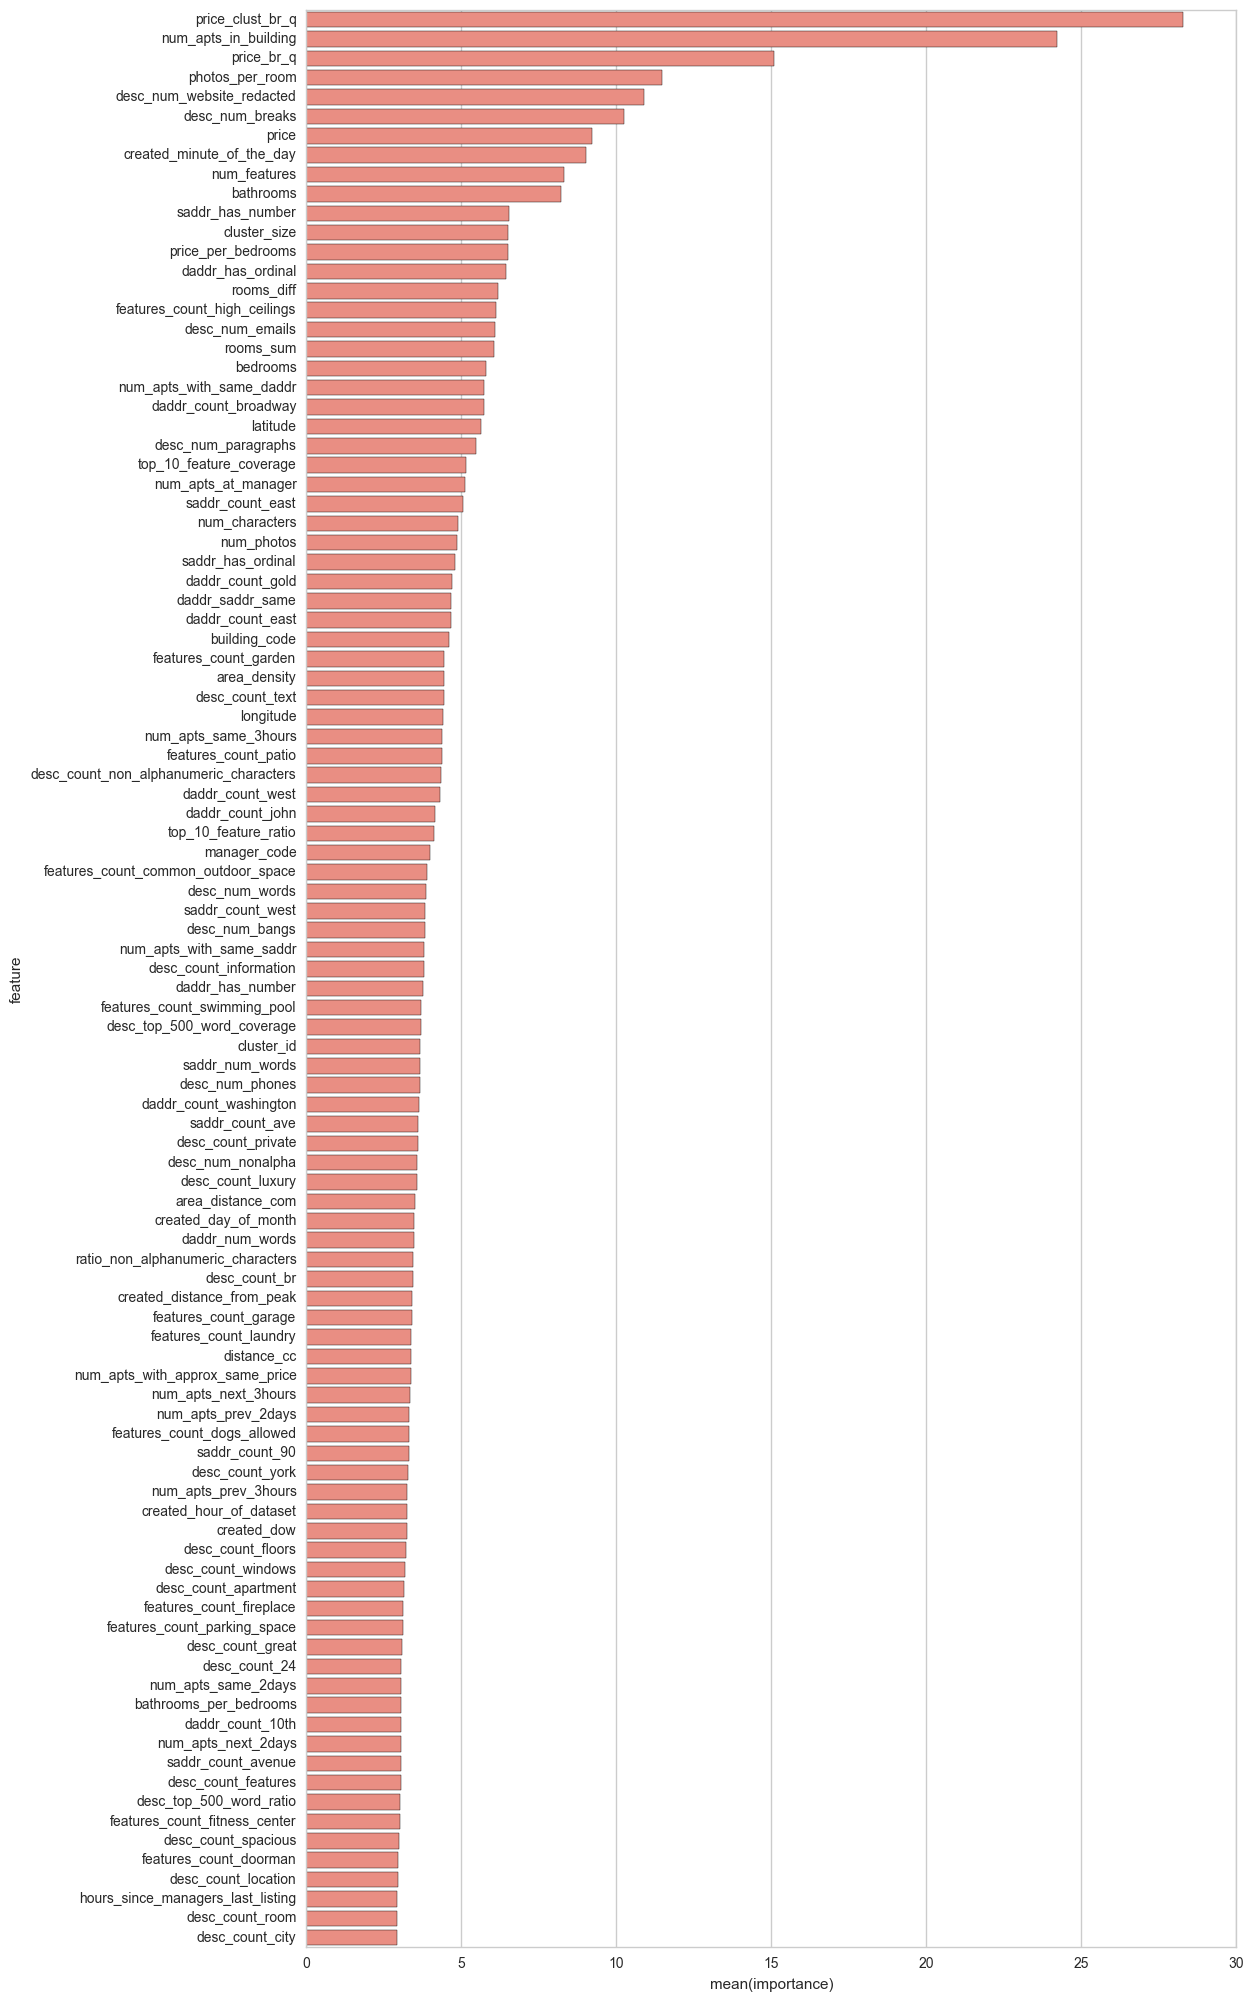

In [103]:
NUM_FEATURES = 100
fscores = m.get_score(importance_type='gain')
fscores = sorted(fscores.items(), key=operator.itemgetter(1))
fscores.reverse()
fscores = fscores[:NUM_FEATURES]
fi = pd.DataFrame({
        'feature': [fs[0] for fs in fscores],
        'importance': [fs[1] for fs in fscores]})
plt.figure(figsize=(12, NUM_FEATURES / 4))
_ = sns.barplot(
        x='importance',
        y='feature',
        data=fi,
        color='salmon')

# Submission

In [118]:
xgtrain = xgb.DMatrix(tr, label=trl)
xgtest = xgb.DMatrix(te)

In [129]:
ps = {}
ps['max_depth'] = 6
ps['eta'] = 0.3
ps['min_child_weight'] = 2
ps['subsample'] = 1.0
ps['colsample_bytree'] = 1.0
ps['colsample_bylevel'] = 1.0
ps['gamma'] = 0.0
ps['lambda'] = 1.0
ps['alpha'] = 0.0
ps['objective'] = 'multi:softprob'
ps['num_class'] = 3
ps['eval_metric'] = 'mlogloss'

In [132]:
model = xgb.train(
            params=ps,
            dtrain=xgtrain,
            num_boost_round=55)
pred_test_y = model.predict(xgtest)

In [149]:
out_df = pd.DataFrame(pred_test_y, index=te.index)
print len(out_df)
out_df.columns = ['low', 'medium', 'high']
out_df.head(10)

74659


,low,medium,high
id,,,
0,0.450993,0.474497,0.074510
1,0.721895,0.190553,0.087552
100,0.737476,0.218253,0.044271
1000,0.543194,0.403018,0.053788
100000,0.737516,0.239819,0.022666
100001,0.970197,0.028481,0.001321
100002,0.762115,0.206965,0.030920
100003,0.512826,0.366010,0.121164
100005,0.553510,0.389323,0.057168


In [150]:
ids = pd.read_json('tmp/raw_data.json')[['listing_id']]
print len(ids)
ids.head()

124011


,listing_id
0,7142618
1,7210040
10,7211212
100,7103890
1000,7143442


In [153]:
s = pd.merge(ids, out_df, left_index=True, right_index=True)
s.head(10)

,listing_id,low,medium,high
0,7142618,0.450993,0.474497,0.074510
1,7210040,0.721895,0.190553,0.087552
100,7103890,0.737476,0.218253,0.044271
1000,7143442,0.543194,0.403018,0.053788
100000,6860601,0.737516,0.239819,0.022666
100001,6840081,0.970197,0.028481,0.001321
100002,6922337,0.762115,0.206965,0.030920
100003,6913616,0.512826,0.366010,0.121164
100005,6937820,0.553510,0.389323,0.057168
100006,6893933,0.716953,0.269832,0.013215


In [154]:
s.to_csv('output/xgb_8.csv', index=False)